In [1]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt

import notebook_utilities as nbutils
tf = nbutils.import_tensorflow()

import gpflow

import domain as dom
import function as fun
import learn as lrn
import utilities as utils

# Dynamical model of an inverted pendulum

In [2]:
# ---------------------------------------------------------------------------*/
# - model an inverted pendulum

# true model parameters of a pendulum system
mass_true = 0.15
friction_true = 0.1
length_true = 0.5
inertia_true = mass_true * length_true ** 2

# wrong model parameters for the pendulum
mass = 0.1 # less mass!!
friction = 0. # no friction!!
length = length_true
gravity = 9.81
inertia = mass * length ** 2

# state saturation
angle_max = np.deg2rad(30)
eigfreq = np.sqrt(gravity/length) # eigen, or natural, frequency
state_max = [angle_max, eigfreq]

# control action saturation, i.e. max torque [m/s^2 * kg * m = kg * m^2 / s^2 = m * N]
torque_max = gravity * mass_true * length_true * np.sin(angle_max)
action_max = torque_max

# instantiate two types of inverted pendulum dynamics, with wrong anf true parameters
pendulum = fun.pendulum_inv(
    mass, length, friction,
    normalization=(state_max, action_max))

pendulum_true = fun.pendulum_inv(
    mass_true, length_true, friction_true,
    normalization=(state_max, action_max))


### Domain discretization

In [3]:
# ---------------------------------------------------------------------------*/
# - discretize a normalized domain

dims_lim = [(-2.0, 2.0), (-1.5, 1.5)]
domain = dom.gridworld(dims_lim, dims_sz=[2001, 1501])

# show domain statistics
print(f'Grid size is {len(domain)}')

tau = np.min(domain.step)
print(f'Discretization step equals {tau:.3f}')

Grid size is 3003501
Discretization step equals 0.002


### Initial optimal policy for a linearized model

In [4]:
# ---------------------------------------------------------------------------*/
# - linearize model dynamics

a, b = pendulum.linearize()

dyn_linear = fun.linear([a, b])
dyn_angle_linear = fun.linear([a[[0], :], b[[0], :]])
dyn_velocity_linear = fun.linear([a[[1], :], b[[1], :]])


# ---------------------------------------------------------------------------*/
# - initial control policy

# lqr cost matrices for state and control,
# which encode how the performance of the angular velocity is
# penalized more, than the angle. Meanwhile, the control cost r is penalized only slightly.
q = 1 * np.diag([1.0, 2.0])
r = 1.2 * np.array([[1.0]])

# compute an optimal policy for the linearized model dynamics
lqr_ctl, lqr_solution = utils.make_dlqr(a, b, q, r)

# lqr policy is u = -K*x,
# where x is the state and K is the full-state feedback matrix
policy_initial = fun.saturated(fun.linear([-lqr_ctl]), 1.0)

### Definition of stochastic models

In [5]:
# ---------------------------------------------------------------------------*/
# - model uncertainty

ab = tf.concat((a, b), axis=1)
ab_true = tf.concat((pendulum_true.linearize()), axis=1)

# compute error (variance) between the true and wrong dynamics
dyn_error = (ab_true - ab) ** 2

error_angle = (
    gpflow.kernels.Linear(variance=dyn_error[0, :], active_dims=np.arange(len(dyn_error[0, :]))) +
    gpflow.kernels.Matern32(lengthscales=1, active_dims=[0]) *
    gpflow.kernels.Linear(variance=dyn_error[0, 1]))

error_velocity = (
    gpflow.kernels.Linear(variance=dyn_error[1, :]) +
    gpflow.kernels.Matern32(lengthscales=1, active_dims=[0]) *
    gpflow.kernels.Linear(variance=dyn_error[1, 1]))

# define observation noise
sample_ns_var = tf.constant(0.01 ** 2, dtype=gpflow.default_float())

# use error information to instantiate stochastic dynamics,
# but do not set any policies right now
dyn_angle = fun.dynamics(dyn_angle_linear, error=error_angle, noise=sample_ns_var)
dyn_velocity = fun.dynamics(dyn_velocity_linear, error=error_velocity, noise=sample_ns_var)

# stack together stochastic functions, which are scalar, to form a vector-valued function
dyn = fun.stochastic_stacked([dyn_angle, dyn_velocity])

# Dynamic programming

### Value function as a Lyapunov function candidate

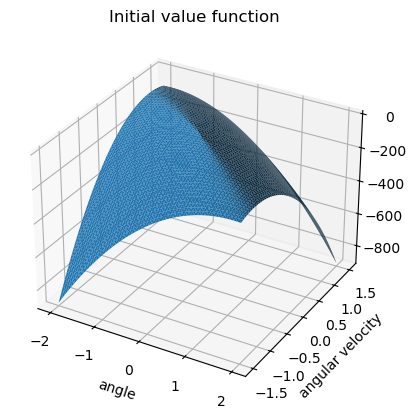

In [6]:
# ---------------------------------------------------------------------------*/
# - value function approximated using triangulation

# define a less-discretized domain to speed up value function computation
domain_value = dom.gridworld(dims_lim, dims_sz=55)

# choose quadratic function as an initial lyapunov function candidate
lyap_initial = fun.quadratic(lqr_solution)

# value function;
# values are initialized with negated values of the initial lyapunov function
value = fun.triangulation(domain_value, -lyap_initial(domain_value.points))

# plot initial value function
fig, ax = utils.plot3d_triangulation(value)
ax.set_title('Initial value function')
ax.set_xlabel("angle")
ax.set_ylabel("angular velocity")
plt.show()


### Configure policy iteration

In [7]:
# ---------------------------------------------------------------------------*/
# - configure policy iteration

# reward function;
# rewards are strictly negative away from the origin and zero at the origin
reward = fun.quadratic(linalg.block_diag(-q, -r))

# policy is a neural network
policy = fun.neuralnetwork(domain.dims_n, layers=[32, 32, 1], activations=['relu', 'relu', 'tanh'])

# use policy iteration to solve this reinforcement learning problem
rl = lrn.policy_iter(policy, dyn, reward, value)

### Run dynamic programming

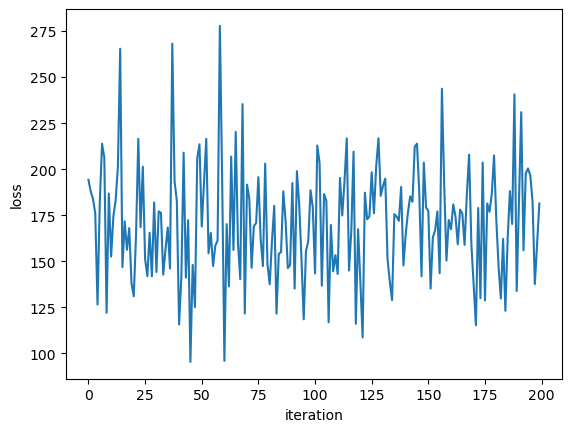

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
losses = []
epochs_n = 200

for epoch in range(epochs_n):

    # evaluate current policy to improve value function
    #opt_values = rl.evaluate(domain_value.states, optimize=True)
    #value._parameters = opt_values

    # use current value function to improve policy
    states = domain.sample_continuous(32)
    with tf.GradientTape() as tape:

        # forward pass
        loss_values = rl.evaluate(states)
        # loss
        loss = -tf.reduce_mean(loss_values)

    # calculate gradients
    grads = tape.gradient(loss, policy._model.trainable_variables)
    # optimizer step
    optimizer.apply_gradients(zip(grads, policy._model.trainable_variables))

    # gather metrics
    losses.append(loss)

# plot loss 
plt.plot(losses) 
plt.xlabel("iteration") 
plt.ylabel("loss") 
plt.show()

# Simulation

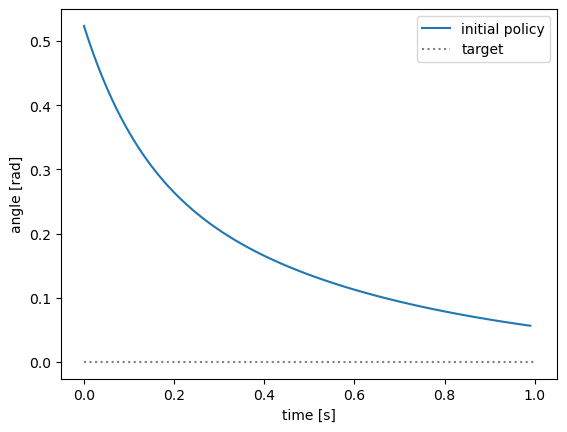

In [9]:
# ---------------------------------------------------------------------------*/
# simulate result and plot

# create a sequence of states for simulation and set the initial state
sim_states = np.zeros((100, 2), dtype=float)
sim_states[0] = [1.0, -0.5] # initial state

# prepare pendulum dynamics for simulation
pendulum_true.policy = policy_initial

# simulate
for this in range(len(sim_states) - 1):
    sim_states[this + 1] = pendulum_true(sim_states[this])

time = np.arange(len(sim_states)) * pendulum_true.timestep
data = pendulum_true.denormalize_state(sim_states)

# plot simulated state trajectory
policy_initial_plt = plt.plot(time, data[:, 0], label=r'initial policy')
plt.xlabel("time [s]")
plt.ylabel("angle [rad]")

# plot policy target, i.e. a pendulum in its upright position, where angle equals 0
policy_target_plt = plt.plot([0, 1], [0, 0], color='grey', linestyle='dotted', label=r'target')

# plot legend
lns = policy_initial_plt + policy_target_plt
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc=1, fancybox=True, framealpha=0.75)

# show plotting
plt.show()